In [52]:
import numpy as np # type: ignore
import os
import pandas as pd  # type: ignore
import matplotlib.pyplot as plt  # type: ignore
import scipy.stats as sis  # type: ignore
import warnings
import seaborn as sns
import scipy.signal as signal
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split  
from sklearn.metrics import confusion_matrix, classification_report

In [53]:
def cargar_dataframe_paciente(ruta):
    df = pd.DataFrame(pd.read_csv(ruta,sep='\t',low_memory=False))
    return df
def clasificar_movimientos(df1):
    n0=df1[df1['class']==0]
    n1=df1[df1['class']==1]
    n2=df1[df1['class']==2]
    n3=df1[df1['class']==3]
    n4=df1[df1['class']==4]
    n5=df1[df1['class']==5]
    n6=df1[df1['class']==6]
    n7=df1[df1['class']==7]
    if len(n7) == 0:
        return n0,n1,n2,n3,n4,n5,n6
    else:
        return n0,n1,n2,n3,n4,n5,n6,n7
def TKEO(signal):
    tkeo = np.zeros_like(signal)    
    for n in range(1, len(signal) - 1):
        tkeo[n] = signal[n]**2 - signal[n-1] * signal[n+1]
    tkeo[0] = 0
    tkeo[-1] = 0    
    return tkeo
def calculate_rms(signal):
    """Calcula el valor RMS (Root Mean Square) de la señal."""
    return np.sqrt(np.mean(np.square(signal)))

def calculate_variance(signal):
    """Calcula la varianza de la señal."""
    return np.var(signal)

def calculate_mav(signal):
    """Calcula el Mean Absolute Value (MAV) de la señal."""
    return np.mean(np.abs(signal))

def calculate_mav_slope(signal):
    """Calcula el Mean Absolute Value Slope (MAVS) de la señal."""
    return np.mean(np.abs(np.diff(signal)))

def calculate_ssc(signal, threshold=0):
    """Calcula el número de Slope Sign Changes (SSC) en la señal."""
    ssc = np.sum(np.diff(np.sign(np.diff(signal))) != 0)
    return ssc

def calculate_wl(signal):
    """Calcula la longitud de la forma de onda (Waveform Length, WL) de la señal."""
    return np.sum(np.abs(np.diff(signal)))

def calculate_zero_crossings(signal):
    """Calcula el número de Zero Crossings (ZC) en la señal."""
    zero_crossings = ((signal[:-1] * signal[1:]) < 0).sum()
    return zero_crossings
def calcular_metricas(dict_senal):
    metricas = {}
    for i in range(len(dict_senal)):
        senal = np.array(dict_senal[f'Clase {i}'])
        rms = calculate_rms(senal)
        var = calculate_variance(senal)
        mav = calculate_mav(senal)
        mav_slope = calculate_mav_slope(senal)
        ssc = calculate_ssc(senal)
        wl = calculate_wl(senal)
        zc = calculate_zero_crossings(senal)
        metricas[f'Clase {i}']=[rms,var,mav,mav_slope,ssc,wl,zc]
    return metricas
def crear_dataframe(metricas):
    lista_metricas = ['RMS','Varianza','Mean Aboslute Value','Mean Absolute Value Slope','Slope Sign Changes','Wave Form Lenght','Zero Crossing']
    df_metricas= pd.DataFrame.from_dict(metricas, orient='index', columns=lista_metricas)
    return df_metricas 


In [54]:
carpeta = input('Ingrese el paciente: ')
# carpeta = '13'
ruta = f'EMG_data_for_gestures-master\\{carpeta}'
series = os.listdir(ruta)
paciente = cargar_dataframe_paciente(ruta+'\\'+series[0])
database = clasificar_movimientos(paciente)

In [55]:
def corte_datos(dataframe):
    n=dataframe.drop(columns=['time','class'])
    return n
def conversion_uni(dataframe):
    dataframe['Average'] = dataframe.mean(axis=1)
    # Crear un nuevo DataFrame con solo la columna de promedios
    df_avg = dataframe[['Average']]
    # Mostrar el nuevo DataFrame
    return df_avg
def crear_clases(dataframe):
    Clases = {}
    try:
        for i in range(0,8):
            df=corte_datos(dataframe[i])
            df=conversion_uni(df)
            Clases[f'Clase {i}']= list(df['Average'])
    except IndexError:
        for i in range(0,7):
            df=corte_datos(dataframe[i])
            df=conversion_uni(df)
            Clases[f'Clase {i}']= list(df['Average'])
    return Clases
def crear_tiempo(dataframe):
    t = []
    for i in range(len(dataframe)):
        tc = len(dataframe[f'Clase {i}'])
        tc = np.arange(0,tc,1)
        t.append(tc)
    return t
def filtrado(dict_clases):
    clases_filtrado={}
    for i in range(len(dict_clases)):
        Fs = 1/0.001 # frecuencia de nyquist
        nyquist = Fs/2
        low_fc = 120/nyquist #frecuencia de corte normalizada respecto nyquist
        low_senal = signal.firwin(100+1,low_fc,pass_zero = 'lowpass',window='hamming')
        salida1 = signal.filtfilt(b=low_senal,a=1,x=dict_clases[f'Clase {i}'])
        high_fc = 10/nyquist
        high_senal = signal.firwin(100+1,high_fc,pass_zero = 'highpass',window='hamming')
        salida2 = signal.filtfilt(b=low_senal,a=1,x=salida1)
        band_fc = [50/nyquist,60/nyquist]
        band_stop = signal.firwin(100+1,band_fc,pass_zero = 'bandstop',window='hamming')
        salida3 = signal.filtfilt(b=high_senal,a=1,x=salida2)
        clases_filtrado[f'Clase {i}']=list(salida3)
    return clases_filtrado


# Importante, aquí estan todas las clases

In [56]:
clases_global=crear_clases(database)


In [57]:
t = crear_tiempo(clases_global)

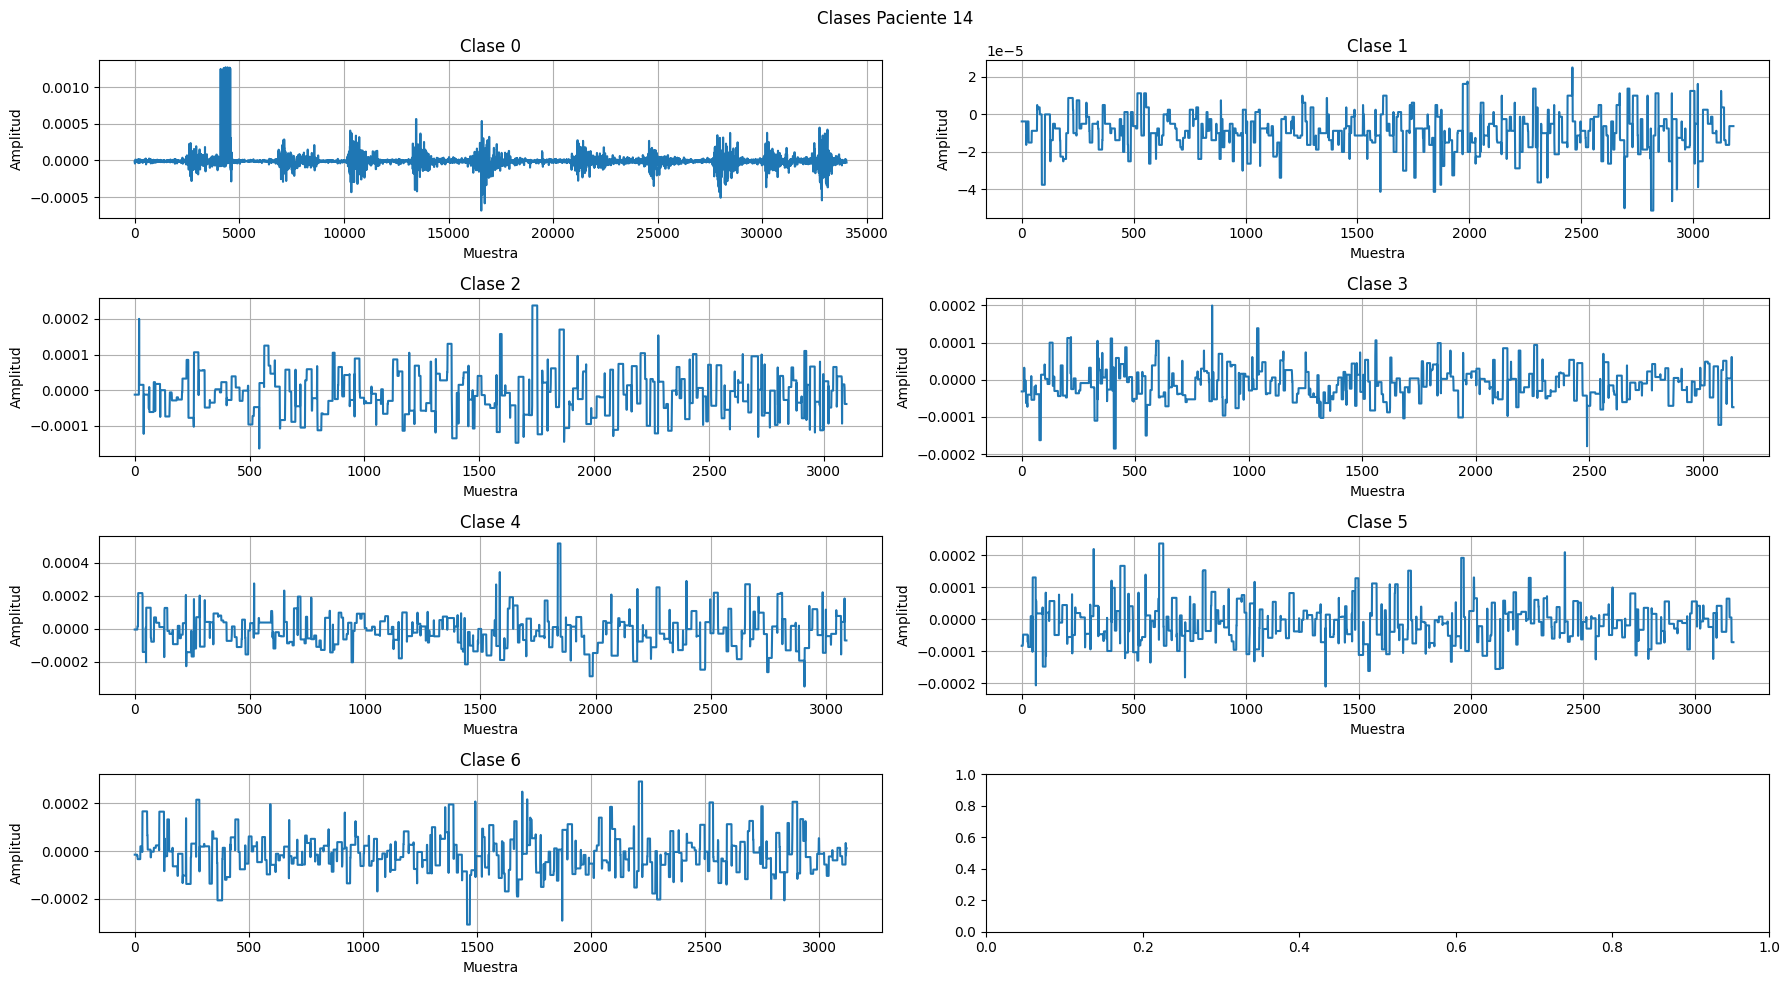

In [58]:
fig,axs=plt.subplots(4,2,figsize=(18,10))
axs=axs.flatten()
for i in range(len(clases_global)):
    axs[i].plot(t[i],clases_global[f'Clase {i}'])
    axs[i].set_title(f'Clase {i}')
    axs[i].grid(True)
    axs[i].set_xlabel('Muestra')
    axs[i].set_ylabel('Amplitud')
plt.suptitle(f'Clases Paciente {carpeta}')
plt.tight_layout()
plt.show()

In [59]:
clases_filtrada = filtrado(clases_global)

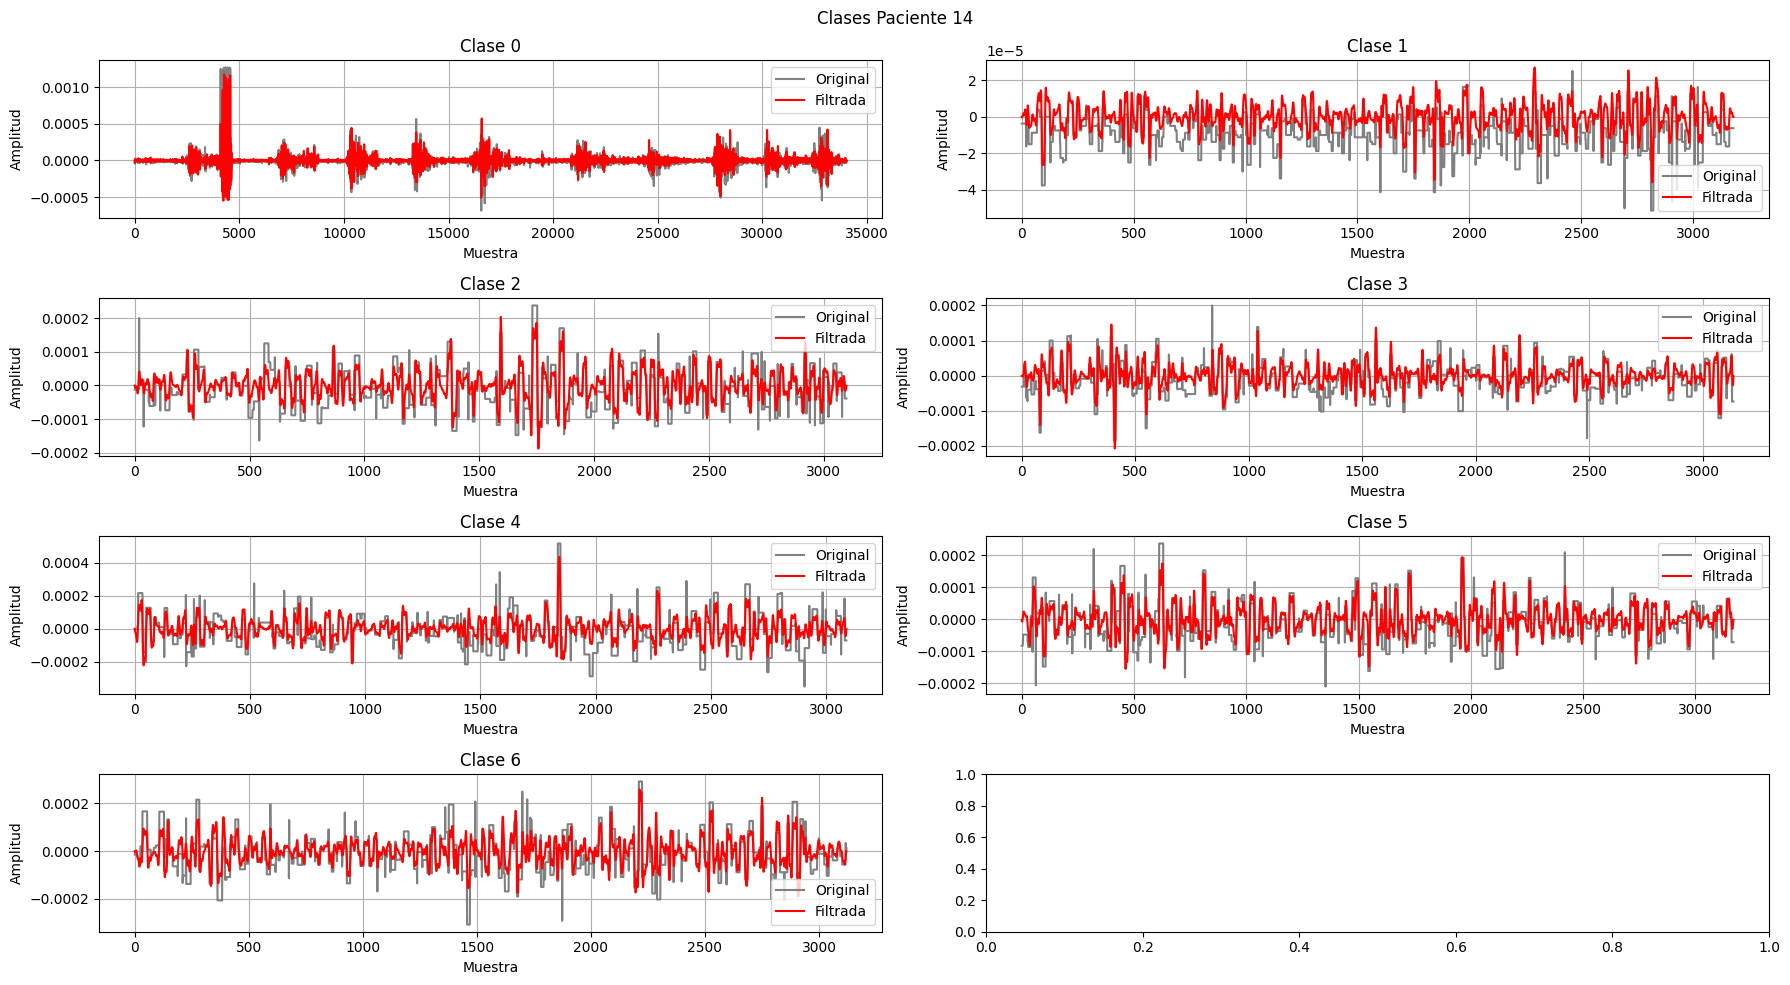

In [60]:
fig,axs=plt.subplots(4,2,figsize=(18,10))
axs=axs.flatten()
for i in range(len(clases_global)):
    axs[i].plot(t[i],clases_global[f'Clase {i}'],color='grey',label='Original')
    axs[i].plot(t[i],clases_filtrada[f'Clase {i}'],color='red',label='Filtrada')
    axs[i].set_title(f'Clase {i}')
    axs[i].grid(True)
    axs[i].set_xlabel('Muestra')
    axs[i].set_ylabel('Amplitud')
    axs[i].legend()
plt.suptitle(f'Clases Paciente {carpeta}')
plt.tight_layout()
plt.show()

TKEO

In [61]:
clases_tkeo = {}
for i in range(len(clases_global)):
    tk = TKEO(clases_global[f'Clase {i}'])
    clases_tkeo[f'Clase {i}']=list(tk)

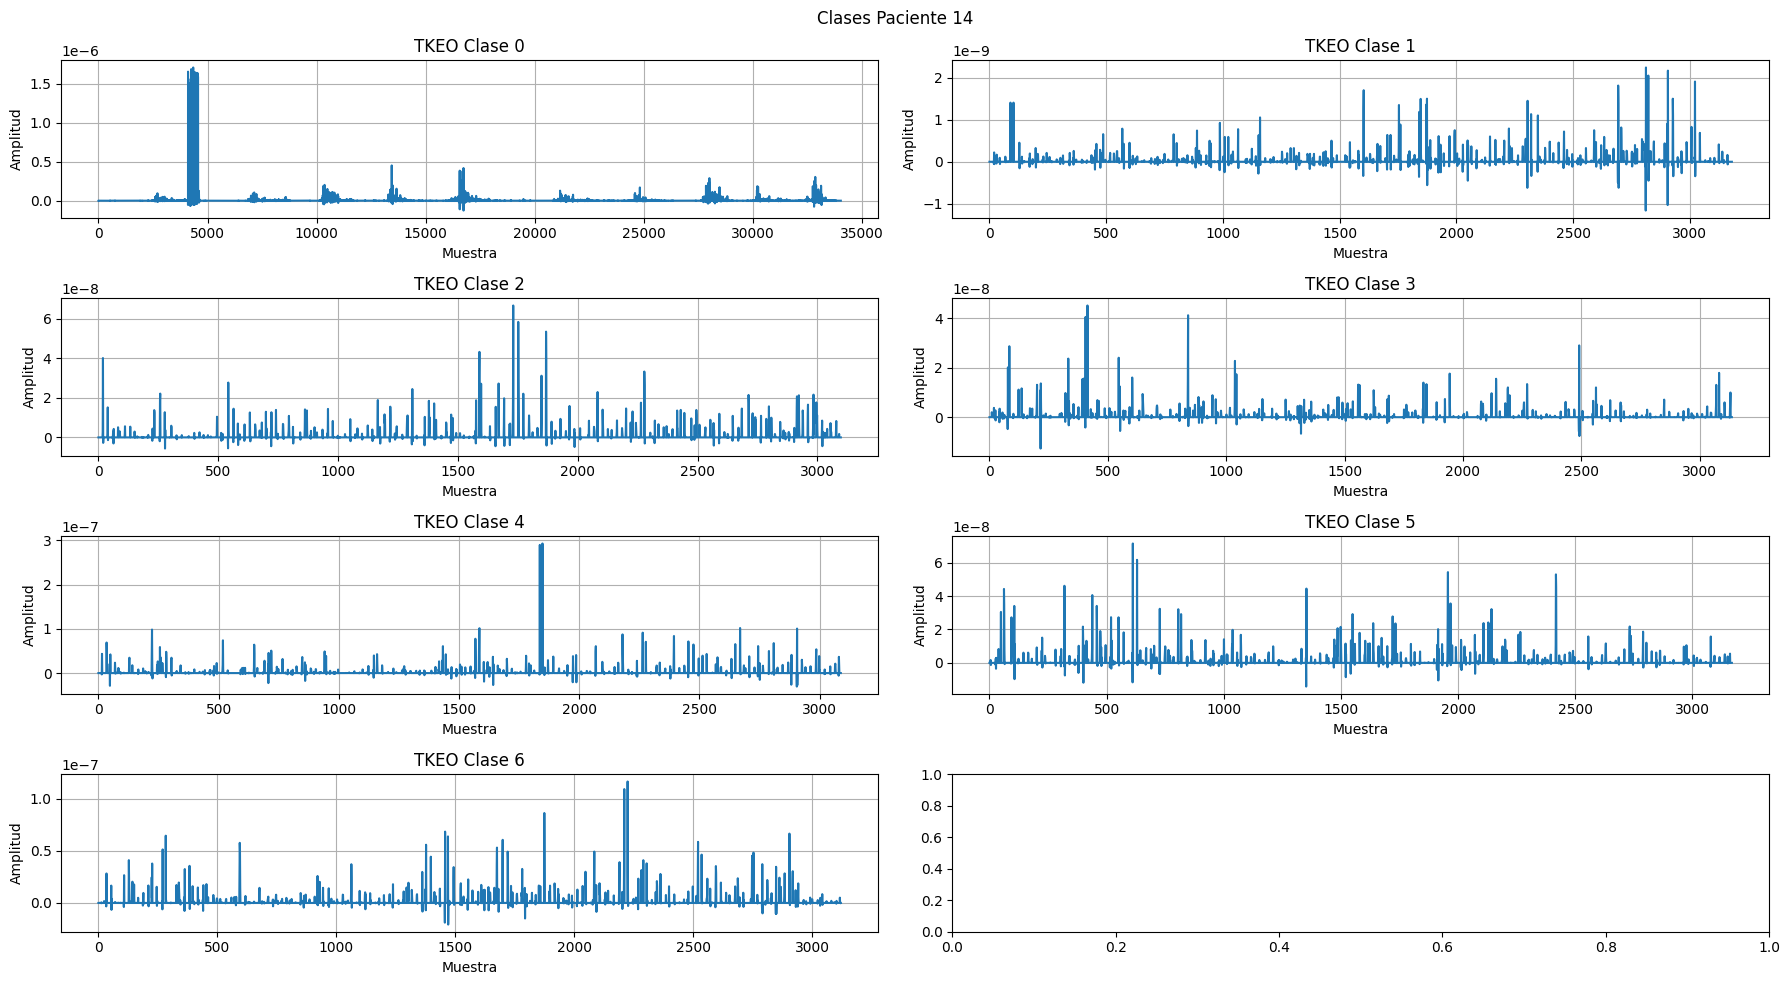

In [62]:
fig,axs=plt.subplots(4,2,figsize=(18,10))
axs=axs.flatten()
for i in range(len(clases_tkeo)):
    axs[i].plot(t[i],clases_tkeo[f'Clase {i}'])
    axs[i].set_title(f'TKEO Clase {i}')
    axs[i].grid(True)
    axs[i].set_xlabel('Muestra')
    axs[i].set_ylabel('Amplitud')
plt.suptitle(f'Clases Paciente {carpeta}')
plt.tight_layout()
plt.show()

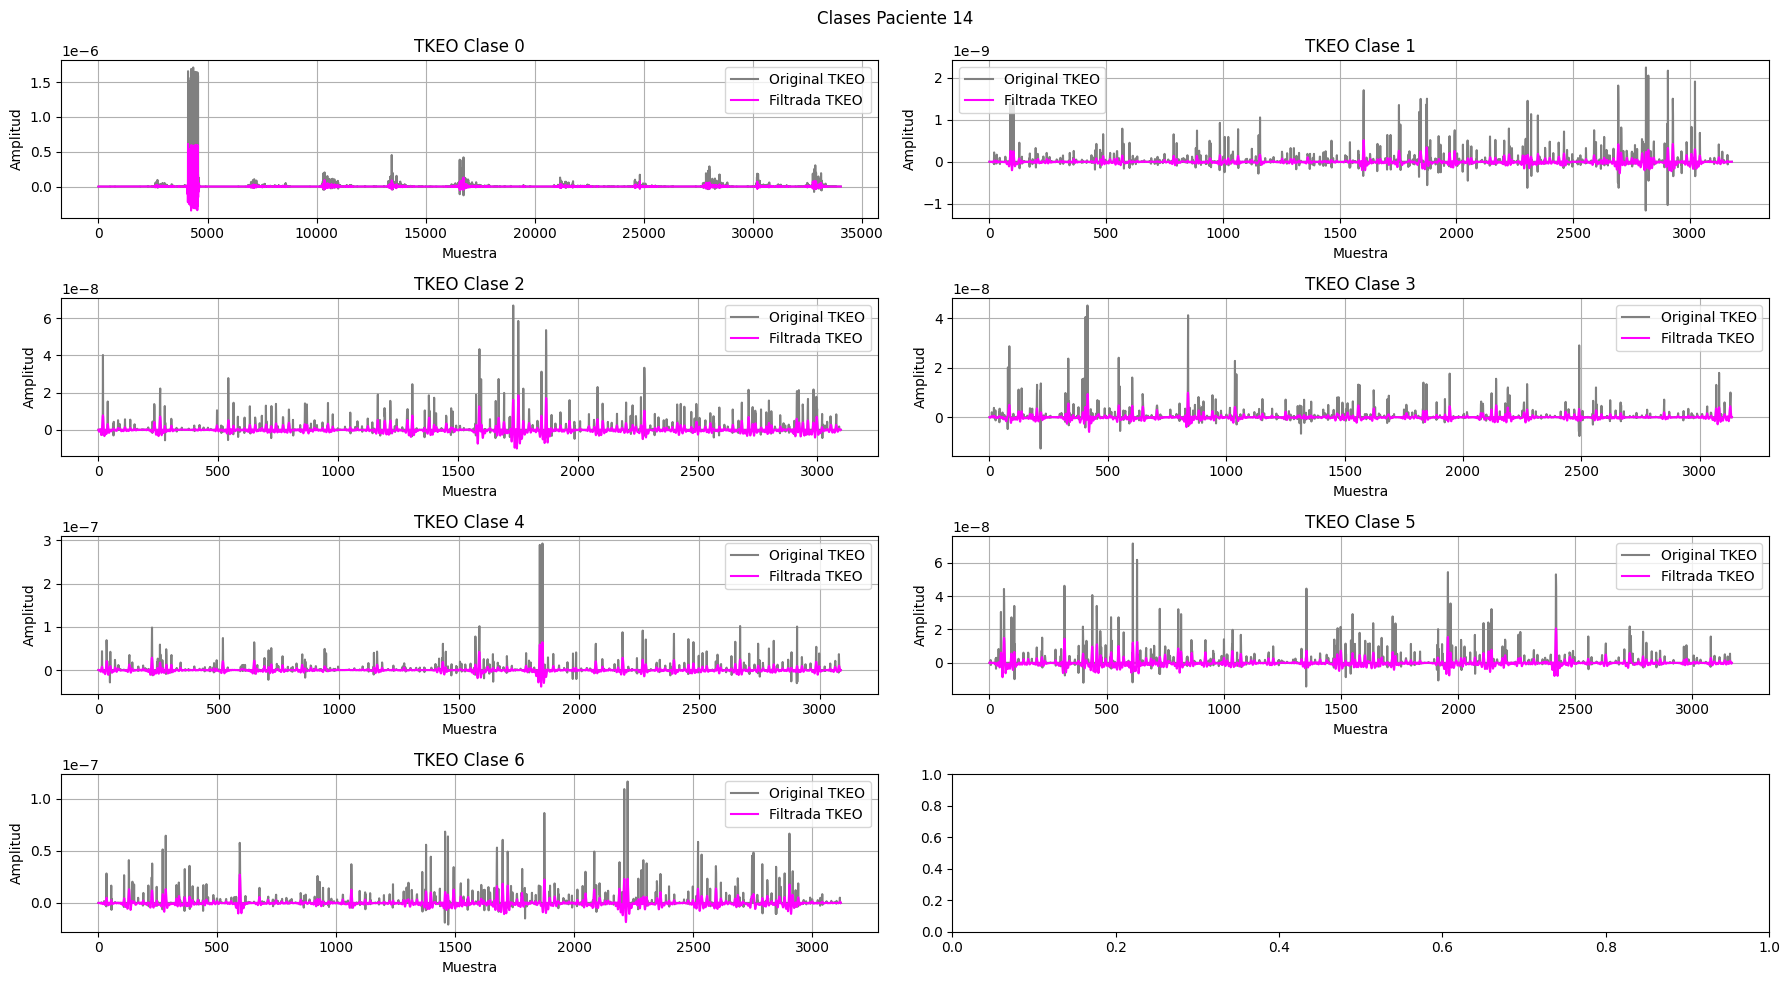

In [63]:
clases_tkeo_filtrado = filtrado(clases_tkeo)
fig,axs=plt.subplots(4,2,figsize=(18,10))
axs=axs.flatten()
for i in range(len(clases_tkeo)):
    axs[i].plot(t[i],clases_tkeo[f'Clase {i}'],color='grey',label='Original TKEO')
    axs[i].plot(t[i],clases_tkeo_filtrado[f'Clase {i}'],color='magenta',label='Filtrada TKEO')
    axs[i].set_title(f'TKEO Clase {i}')
    axs[i].grid(True)
    axs[i].set_xlabel('Muestra')
    axs[i].set_ylabel('Amplitud')
    axs[i].legend()
plt.suptitle(f'Clases Paciente {carpeta}')
plt.tight_layout()
plt.show()

### Recordar
- Indice [0] = RMS
- Indice [1] = Varianza
- Indice [2] = Mean Absolute Value
- Indice [3] = Mean Absolute Value Slope
- Indice [4] = Slope Sign Changes
- Indice [5] = Wave Form Lenght
- Indice [7] = Zero Crossing


In [64]:
metricas_original = calcular_metricas(clases_global)
metricas_filtrado = calcular_metricas(clases_filtrada)
metricas_TKEO = calcular_metricas(clases_tkeo)
metricas_TKEO_filt = calcular_metricas(clases_tkeo_filtrado)


In [65]:
df_met_org = crear_dataframe(metricas_original)
df_met_filt = crear_dataframe(metricas_filtrado)
df_met_tkeo = crear_dataframe(metricas_TKEO)
df_met_tkeo_filt = crear_dataframe(metricas_TKEO_filt)

In [66]:
print("Métricas Clases Originales")
display(df_met_org)
print("Métricas Clases Filtradas")
display(df_met_filt)
print("Métricas Clases TKEO")
display(df_met_tkeo)
print("Métricas Clases TKEO Filtradas")
display(df_met_tkeo_filt)

Métricas Clases Originales


,RMS,Varianza,Mean Aboslute Value,Mean Absolute Value Slope,Slope Sign Changes,Wave Form Lenght,Zero Crossing
Clase 0,0.000099,9.765347e-09,0.000045,0.000008,6086,0.260829,1544
Clase 1,0.000014,1.086428e-10,0.000011,0.000001,608,0.004588,107
Clase 2,0.000065,4.157417e-09,0.000052,0.000008,476,0.024154,162
Clase 3,0.000047,2.126012e-09,0.000037,0.000006,552,0.018447,166
Clase 4,0.000108,1.141488e-08,0.000084,0.000013,499,0.039901,172
Clase 5,0.000066,4.216249e-09,0.000051,0.000009,561,0.028201,194
Clase 6,0.000086,7.331744e-09,0.000066,0.000011,587,0.033443,169


Métricas Clases Filtradas


,RMS,Varianza,Mean Aboslute Value,Mean Absolute Value Slope,Slope Sign Changes,Wave Form Lenght,Zero Crossing
Clase 0,0.000070,4.881924e-09,0.000031,0.000008,5606,0.258917,2436
Clase 1,0.000008,5.793844e-11,0.000006,0.000001,521,0.004395,226
Clase 2,0.000044,1.954138e-09,0.000033,0.000007,495,0.021471,198
Clase 3,0.000033,1.087390e-09,0.000024,0.000006,520,0.018323,230
Clase 4,0.000066,4.378648e-09,0.000049,0.000011,485,0.034047,214
Clase 5,0.000045,2.069330e-09,0.000034,0.000008,527,0.024314,232
Clase 6,0.000056,3.184940e-09,0.000043,0.000010,505,0.030853,219


Métricas Clases TKEO


,RMS,Varianza,Mean Aboslute Value,Mean Absolute Value Slope,Slope Sign Changes,Wave Form Lenght,Zero Crossing
Clase 0,5.215847e-08,2.713312e-15,2.907505e-09,4.543397e-09,9402,1.545800e-04,2117
Clase 1,1.621989e-10,2.567204e-20,3.833700e-11,6.615075e-11,980,2.103594e-07,264
Clase 2,3.764882e-09,1.361537e-17,8.544677e-10,1.242642e-09,707,3.849706e-06,145
Clase 3,2.434667e-09,5.735306e-18,5.312694e-10,8.357173e-10,872,2.620809e-06,177
Clase 4,1.175543e-08,1.341507e-16,2.406956e-09,3.680374e-09,762,1.136499e-05,152
Clase 5,4.489137e-09,1.934057e-17,1.051241e-09,1.571577e-09,798,4.980328e-06,185
Clase 6,7.039769e-09,4.759255e-17,1.656191e-09,2.534122e-09,848,7.906459e-06,190


Métricas Clases TKEO Filtradas


,RMS,Varianza,Mean Aboslute Value,Mean Absolute Value Slope,Slope Sign Changes,Wave Form Lenght,Zero Crossing
Clase 0,2.517288e-08,6.336697e-16,3.772358e-09,1.695380e-09,6406,5.768191e-05,4532
Clase 1,6.238554e-11,3.891580e-21,3.573359e-11,1.604758e-11,585,5.103130e-08,428
Clase 2,1.987745e-09,3.950731e-18,1.117398e-09,5.073156e-10,599,1.571664e-06,420
Clase 3,1.054316e-09,1.111347e-18,5.940573e-10,2.612717e-10,597,8.193479e-07,395
Clase 4,5.687149e-09,3.234021e-17,2.994914e-09,1.359353e-09,581,4.197683e-06,411
Clase 5,2.269107e-09,5.148333e-18,1.303438e-09,5.814955e-10,588,1.842759e-06,413
Clase 6,3.506422e-09,1.229376e-17,2.027213e-09,8.993257e-10,582,2.805896e-06,402


Implementación de Modelo Scikit

In [67]:
y = df_met_tkeo_filt['RMS'].values
X = df_met_tkeo_filt.drop('RMS', axis=1).values

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=42) 
X_train.shape, X_test.shape

((4, 6), (3, 6))

In [70]:
# Create the classifier: logreg
logreg = LogisticRegression()

# Fit the classifier to the training data
logreg.fit(X_train, y_train)

ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.